In [ ]:
import cartopy.crs as ccrs
import cmocean.cm as cmo
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import xarray as xr
import xesmf as xe

import jaxparrow as jpw
from jaxparrow.tools.geometry import compute_uv_grids
from jaxparrow.tools.kinematics import magnitude, normalized_relative_vorticity
from jaxparrow.tools.operators import interpolation


jax.config.update("jax_enable_x64", True)

In [2]:
def fill_1d_linear_nearest(arr, interp_dim, nearest_dim):
    da = xr.DataArray(arr, dims=("y", "x"))

    filled = da.interpolate_na(dim=interp_dim, method="slinear", fill_value="extrapolate")
    filled = filled.interpolate_na(dim=nearest_dim, method="nearest")

    return filled.values


def preprocess_swot(swot_ds, descending_pass=False):
    swot_ds = swot_ds.rename({"longitude": "lon", "latitude": "lat"}).set_coords(["lon", "lat"])
    swot_ds["lon"] = ((swot_ds["lon"] + 180) % 360) - 180

    med_mask = (
        (swot_ds["lat"] > 30.0681) & (swot_ds["lat"] < 47.3764) & 
        (swot_ds["lon"] > -6.0326) & (swot_ds["lon"] < 42.355)
    )
    swot_ds = swot_ds.where(med_mask, drop=True)

    sea_mask = ~np.isnan(swot_ds["ssha_filtered"])
    min_lat, max_lat = swot_ds["lat"].where(sea_mask).min(), swot_ds["lat"].where(sea_mask).max()
    min_lon, max_lon = swot_ds["lon"].where(sea_mask).min(), swot_ds["lon"].where(sea_mask).max()
    swot_ds = swot_ds.where(
        (swot_ds["lat"] >= min_lat) & (swot_ds["lat"] <= max_lat) &
        (swot_ds["lon"] >= min_lon) & (swot_ds["lon"] <= max_lon),
        drop=True
    )

    if descending_pass:
        swot_ds = swot_ds.reindex(num_lines=swot_ds.num_lines[::-1], num_pixels=swot_ds.num_pixels[::-1])
        swot_ds = swot_ds.reindex(num_lines=swot_ds.num_lines[::-1], num_pixels=swot_ds.num_pixels[::-1])

    karin_mask = (np.abs(swot_ds.cross_track_distance) <= 60.0) & (np.abs(swot_ds.cross_track_distance) >= 10.0)
    swot_ds = swot_ds.where(karin_mask)

    return swot_ds, karin_mask


def open_enatl60_dataset(ds_path):
    enatl60_ds = xr.open_dataset(ds_path).isel(time_counter=0).drop_vars("time_counter")
    enatl60_ds = enatl60_ds.rename({"nav_lon": "lon", "nav_lat": "lat"}).set_coords(["lon", "lat"])
    return enatl60_ds


def get_swot_mask(enatl60_dss, swot_dss):
    swot_mask = False
    for enatl60_ds in enatl60_dss:
        for swot_ds in swot_dss:
            mask = ~(
                (enatl60_ds["lat"] < swot_ds["lat"].min()) | (enatl60_ds["lat"] > swot_ds["lat"].max()) |
                (enatl60_ds["lon"] < swot_ds["lon"].min()) | (enatl60_ds["lon"] > swot_ds["lon"].max())
            )
            swot_mask = swot_mask | mask
    return swot_mask


def preprocess_enatl60(enatl60_ds, enatl60_mask, swot_mask):
    enatl60_ds = enatl60_ds.where(swot_mask, drop=True)
    
    sea_mask = enatl60_mask.isel(t=0, z=0).where(swot_mask, drop=True)
    enatl60_ds = enatl60_ds.where(sea_mask, drop=True)

    invalid_mask = (enatl60_ds.lat == 0) & (enatl60_ds.lon == 0)
    lat = xr.where(invalid_mask, np.nan, enatl60_ds.lat)
    lon = xr.where(invalid_mask, np.nan, enatl60_ds.lon)

    valid_lat = fill_1d_linear_nearest(lat.values, interp_dim="x", nearest_dim="y")
    valid_lon = fill_1d_linear_nearest(lon.values, interp_dim="y", nearest_dim="x")

    enatl60_ds["lat"] = xr.where(invalid_mask, valid_lat, enatl60_ds.lat)
    enatl60_ds["lon"] = xr.where(invalid_mask, valid_lon, enatl60_ds.lon)
    
    return enatl60_ds


def get_regridder(enatl60_ds, swot_ds):
    regridder = xe.Regridder(enatl60_ds, swot_ds, "bilinear")
    return regridder


def regrid_enatl60_variable(enatl60_var_da, regridder):
    regridded_da = regridder(enatl60_var_da)
    return regridded_da


def arr_to_da(arr, lat, lon, name, units=None):
    attrs = {"long_name": name}
    if units is not None:
        attrs["units"] = units

    return xr.DataArray(
        arr,
        dims=("y", "x"),
        coords={"lat": (("y", "x"), lat.values), "lon": (("y", "x"), lon.values)},
        attrs=attrs
    )

In [ ]:
ENATL60_VARS_PATH = "/summer/meom/MODEL_SET/eNATL60/eNATL60-BLB002/1d/eNATL60"
ENATL60_MASK_PATH = "/summer/meom/MODEL_SET/eNATL60/eNATL60-I/mask_eNATL60_3.6.nc"
SWOT_PATH = "/summer/meom/workdir/bertrava/cyclogeostrophy-paper/SWOT"

# Produce pseudo-SWOT SSH data from eNATL60

This is done by regridding eNATL60 data onto the SWOT KaRin-swath grid.
Notes:
- use of several masks to avoid regridding over land or outside of SWOT bounding box,
- linear and nearest-neighbor reinterpolation of eNATL60 latitude and longitude whose values are (0, 0) to avoid potential regridding artifacts,
- separate regridding for the T, U, and V grids.

In [ ]:
swot_003_ds = xr.open_dataset(f"{SWOT_PATH}/SWOT_L3_LR_SSH_Expert_003_v2.0.1.nc")
swot_003_ds, karin_003_mask = preprocess_swot(swot_003_ds)

swot_016_ds = xr.open_dataset(f"{SWOT_PATH}/SWOT_L3_LR_SSH_Expert_016_v2.0.1.nc")
swot_016_ds, karin_016_mask = preprocess_swot(swot_016_ds, descending_pass=True)

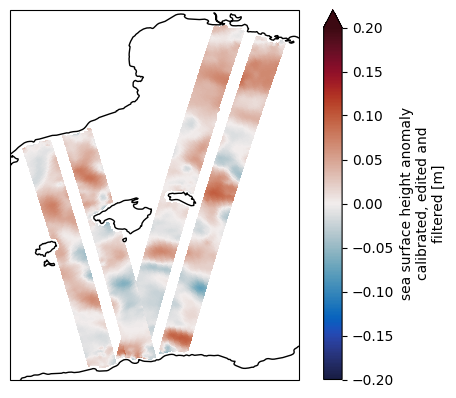

In [4]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
swot_003_ds.ssha_filtered.plot.pcolormesh(ax=ax, x="lon", y="lat", vmin=-.2, vmax=.2, cmap=cmo.balance)
swot_016_ds.ssha_filtered.plot.pcolormesh(
    ax=ax, x="lon", y="lat", vmin=-.2, vmax=.2, cmap=cmo.balance, add_colorbar=False
)
ax.coastlines()
plt.show()

In [ ]:
enatl60_mask_ds = xr.open_dataset(ENATL60_MASK_PATH)
enatl60_t_ds = open_enatl60_dataset(f"{ENATL60_VARS_PATH}/eNATL60-BLB002_y2009m07d01.1d_SSH.nc")
enatl60_u_ds = open_enatl60_dataset(f"{ENATL60_VARS_PATH}/eNATL60-BLB002_y2009m07d01.1d_SSU.nc")
enatl60_v_ds = open_enatl60_dataset(f"{ENATL60_VARS_PATH}/eNATL60-BLB002_y2009m07d01.1d_SSV.nc")

In [6]:
swot_mask = get_swot_mask([enatl60_t_ds, enatl60_u_ds, enatl60_v_ds], [swot_003_ds, swot_016_ds])

In [7]:
enatl60_t_ds = preprocess_enatl60(enatl60_t_ds, enatl60_mask_ds.tmask, swot_mask)
enatl60_u_ds = preprocess_enatl60(enatl60_u_ds, enatl60_mask_ds.umask, swot_mask)
enatl60_v_ds = preprocess_enatl60(enatl60_v_ds, enatl60_mask_ds.vmask, swot_mask)

In [8]:
enatl60_t_ds["uv"] = (
    ("y", "x"),
    np.asarray(magnitude(jnp.asarray(enatl60_u_ds.sozocrtx.values), jnp.asarray(enatl60_v_ds.somecrty.values))),
    {"units": "m/s", "long_name": "surface current (eNATL60)"}
)

In [9]:
enatl60_lat_t = jnp.asarray(enatl60_t_ds.lat)
enatl60_lon_t = jnp.asarray(enatl60_t_ds.lon)

enatl60_lat_u, enatl60_lon_u, enatl60_lat_v, enatl60_lon_v = compute_uv_grids(enatl60_lat_t, enatl60_lon_t)

In [10]:
enatl60_t_ds["nrv"] = (
    ("y", "x"),
    np.asarray(
        normalized_relative_vorticity(
            jnp.asarray(enatl60_u_ds.sozocrtx.values), jnp.asarray(enatl60_v_ds.somecrty.values),
            enatl60_lat_u, enatl60_lon_u, enatl60_lat_v, enatl60_lon_v
        )
    ),
    {"long_name": "normalized relative vorticity (eNATL60)"}
)

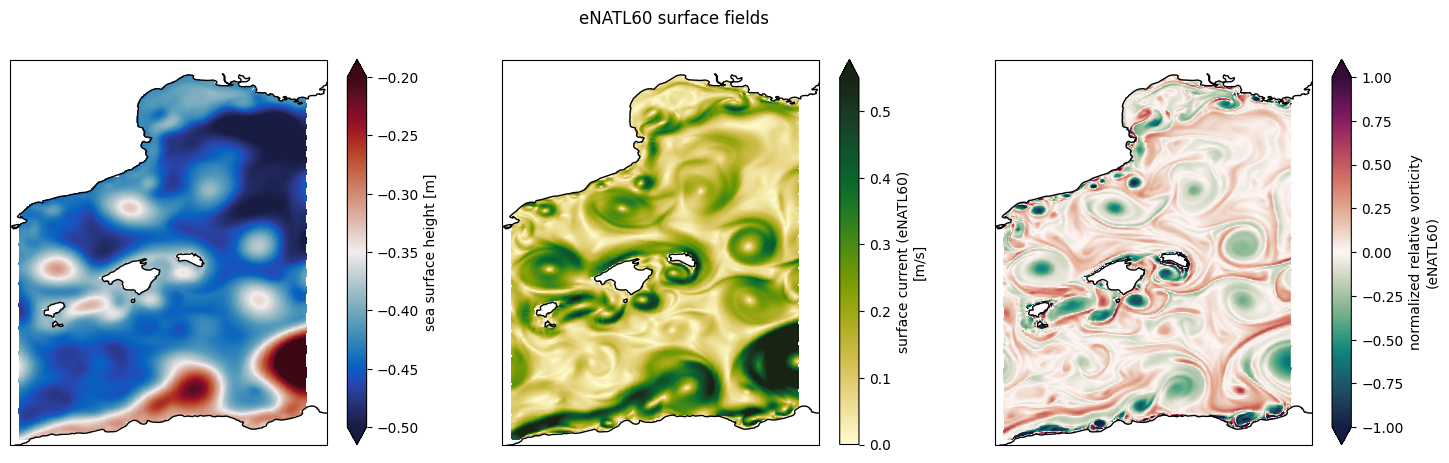

In [11]:
fig, axes = plt.subplots(1, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(18, 5))

enatl60_t_ds.sossheig.plot.pcolormesh(ax=axes[0], x="lon", y="lat", vmin=-0.5, vmax=-0.2, cmap=cmo.balance)
axes[0].coastlines()
enatl60_t_ds.uv.plot.pcolormesh(ax=axes[1], x="lon", y="lat", vmin=0, vmax=0.55, cmap=cmo.speed)
axes[1].coastlines()
enatl60_t_ds.nrv.plot.pcolormesh(ax=axes[2], x="lon", y="lat", vmin=-1, vmax=1, cmap=cmo.curl)
axes[2].coastlines()

fig.suptitle("eNATL60 surface fields")
plt.show()

In [12]:
t_003_regridder = get_regridder(enatl60_t_ds, swot_003_ds)
u_003_regridder = get_regridder(enatl60_u_ds, swot_003_ds)
v_003_regridder = get_regridder(enatl60_v_ds, swot_003_ds)

In [13]:
t_016_regridder = get_regridder(enatl60_t_ds, swot_016_ds)
u_016_regridder = get_regridder(enatl60_u_ds, swot_016_ds)
v_016_regridder = get_regridder(enatl60_v_ds, swot_016_ds)

In [14]:
ssh_003_da = regrid_enatl60_variable(enatl60_t_ds.sossheig, t_003_regridder)
uv_003_da = regrid_enatl60_variable(enatl60_t_ds.uv, t_003_regridder)
nrv_003_da = regrid_enatl60_variable(enatl60_t_ds.nrv, t_003_regridder)
u_003_da = regrid_enatl60_variable(enatl60_u_ds.sozocrtx, u_003_regridder)
v_003_da = regrid_enatl60_variable(enatl60_v_ds.somecrty, v_003_regridder)

In [15]:
ssh_003_da.attrs["units"] = "m"
ssh_003_da.attrs["long_name"] = "sea surface height"
uv_003_da.attrs["units"] = "m/s"
uv_003_da.attrs["long_name"] = "surface current (eNATL60)"
nrv_003_da.attrs["long_name"] = "normalized relative vorticity (eNATL60)"

In [16]:
ssh_016_da = regrid_enatl60_variable(enatl60_t_ds.sossheig, t_016_regridder)
uv_016_da = regrid_enatl60_variable(enatl60_t_ds.uv, t_016_regridder)
nrv_016_da = regrid_enatl60_variable(enatl60_t_ds.nrv, t_016_regridder)
u_016_da = regrid_enatl60_variable(enatl60_u_ds.sozocrtx, u_016_regridder)
v_016_da = regrid_enatl60_variable(enatl60_v_ds.somecrty, v_016_regridder)

In [17]:
ssh_016_da.attrs["units"] = "m"
ssh_016_da.attrs["long_name"] = "sea surface height"
uv_016_da.attrs["units"] = "m/s"
uv_016_da.attrs["long_name"] = "surface current (eNATL60)"
nrv_016_da.attrs["long_name"] = "normalized relative vorticity (eNATL60)"

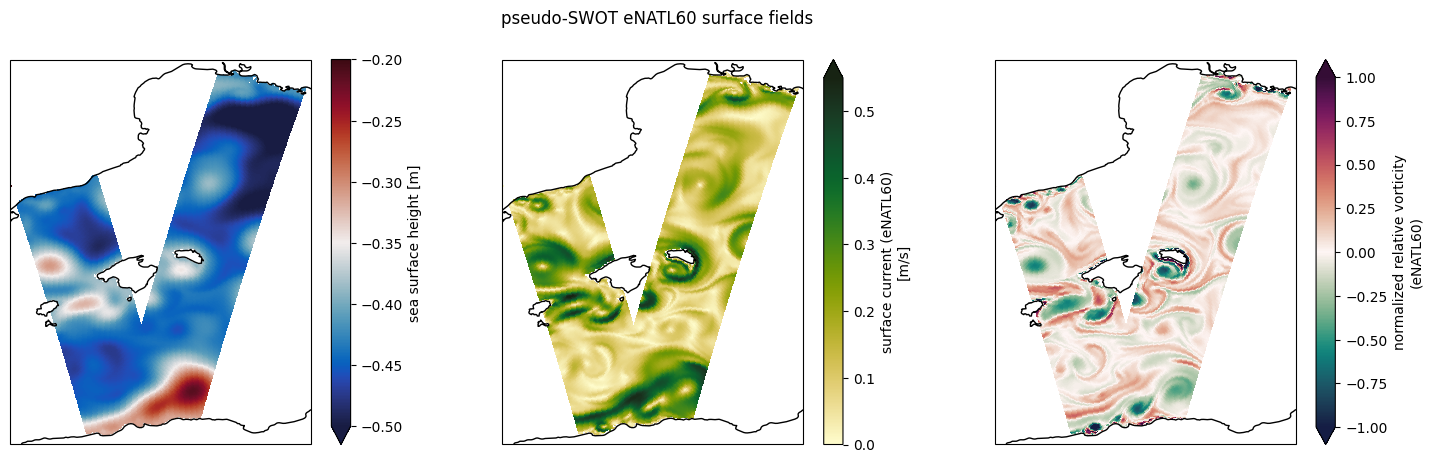

In [ ]:
fig, axes = plt.subplots(1, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(18, 5))

ssh_003_da.where(karin_003_mask).plot.pcolormesh(ax=axes[0], x="lon", y="lat", vmin=-0.5, vmax=-0.2, cmap=cmo.balance)
ssh_016_da.where(karin_016_mask).plot.pcolormesh(
    ax=axes[0], x="lon", y="lat", vmin=-0.5, vmax=-0.2, cmap=cmo.balance, add_colorbar=False
)
axes[0].coastlines()

uv_003_da.where(karin_003_mask).plot.pcolormesh(ax=axes[1], x="lon", y="lat", vmin=0, vmax=0.55, cmap=cmo.speed)
uv_016_da.where(karin_016_mask).plot.pcolormesh(
    ax=axes[1], x="lon", y="lat", vmin=0, vmax=0.55, cmap=cmo.speed, add_colorbar=False
)
axes[1].coastlines()

nrv_003_da.where(karin_003_mask).plot.pcolormesh(ax=axes[2], x="lon", y="lat", vmin=-1, vmax=1, cmap=cmo.curl)
nrv_016_da.where(karin_016_mask).plot.pcolormesh(
    ax=axes[2], x="lon", y="lat", vmin=-1, vmax=1, cmap=cmo.curl, add_colorbar=False
)
axes[2].coastlines()

fig.suptitle("pseudo-SWOT eNATL60 surface fields")
plt.show()

# Surface currents inversion of the pseudo-SWOT SSH data

In [19]:
optim = optax.sgd(learning_rate=5e-3)
optim = optax.chain(optax.clip(1), optim)

In [20]:
swot_003_lat_t = jnp.asarray(swot_003_ds.lat)
swot_003_lon_t = jnp.asarray(swot_003_ds.lon)

In [21]:
u_cg_var_003, v_cg_var_003, u_g_003, v_g_003, lat_u_003, lon_u_003, lat_v_003, lon_v_003 = jpw.cyclogeostrophy(
    jnp.asarray(ssh_003_da.values), swot_003_lat_t, swot_003_lon_t, optim=optim, return_geos=True, return_grids=True
)

In [22]:
u_cg_it_003, v_cg_it_003 = jpw.cyclogeostrophy(
    jnp.asarray(ssh_003_da.values), swot_003_lat_t, swot_003_lon_t, 
    method="iterative", return_geos=False, return_grids=False
)

In [23]:
uv_g_003, uv_cg_var_003, uv_cg_it_003 = map(
    lambda args: magnitude(*args), ((u_g_003, v_g_003), (u_cg_var_003, v_cg_var_003), (u_cg_it_003, v_cg_it_003))
)

In [24]:
nrv_g_003, nrv_cg_var_003, nrv_cg_it_003 = map(
    lambda args: normalized_relative_vorticity(*args, lat_u_003, lon_u_003, lat_v_003, lon_v_003), 
    ((u_g_003, v_g_003), (u_cg_var_003, v_cg_var_003), (u_cg_it_003, v_cg_it_003))
)

In [25]:
optim = optax.sgd(learning_rate=5e-3)
optim = optax.chain(optax.clip(1), optim)

In [26]:
swot_016_lat_t = jnp.asarray(swot_016_ds.lat)
swot_016_lon_t = jnp.asarray(swot_016_ds.lon)

In [27]:
u_cg_var_016, v_cg_var_016, u_g_016, v_g_016, lat_u_016, lon_u_016, lat_v_016, lon_v_016 = jpw.cyclogeostrophy(
    jnp.asarray(ssh_016_da.values), swot_016_lat_t, swot_016_lon_t, optim=optim, return_geos=True, return_grids=True
)

In [28]:
u_cg_it_016, v_cg_it_016 = jpw.cyclogeostrophy(
    jnp.asarray(ssh_016_da.values), swot_016_lat_t, swot_016_lon_t, 
    method="iterative", return_geos=False, return_grids=False
)

In [29]:
uv_g_016, uv_cg_var_016, uv_cg_it_016 = map(
    lambda args: magnitude(*args), ((u_g_016, v_g_016), (u_cg_var_016, v_cg_var_016), (u_cg_it_016, v_cg_it_016))
)

In [30]:
nrv_g_016, nrv_cg_var_016, nrv_cg_it_016 = map(
    lambda args: normalized_relative_vorticity(*args, lat_u_016, lon_u_016, lat_v_016, lon_v_016), 
    ((u_g_016, v_g_016), (u_cg_var_016, v_cg_var_016), (u_cg_it_016, v_cg_it_016))
)

# Comparison with eNATL60 surface currents

Note: we have to interpolate SWOT U and V data onto the SWOT T grid.

In [31]:
u_g_003, u_cg_var_003, u_cg_it_003 = map(
    lambda arr: interpolation(arr, mask=~jnp.isfinite(arr), axis=1, padding="left"), 
    (u_g_003, u_cg_var_003, u_cg_it_003)
)
v_g_003, v_cg_var_003, v_cg_it_003 = map(
    lambda arr: interpolation(arr, mask=~jnp.isfinite(arr), axis=0, padding="left"), 
    (v_g_003, v_cg_var_003, v_cg_it_003)
)

In [32]:
(
    u_g_003, v_g_003, u_cg_var_003, v_cg_var_003, u_cg_it_003, v_cg_it_003, uv_g_003, uv_cg_var_003, uv_cg_it_003, 
    nrv_g_003, nrv_cg_var_003, nrv_cg_it_003
) = map(
    lambda arr: jnp.where(karin_003_mask.values.T, arr, jnp.nan), 
    (
        u_g_003, v_g_003, u_cg_var_003, v_cg_var_003, u_cg_it_003, v_cg_it_003, uv_g_003, uv_cg_var_003, uv_cg_it_003, 
        nrv_g_003, nrv_cg_var_003, nrv_cg_it_003
    )
)

In [33]:
uv_g_003_da, uv_cg_var_003_da, uv_cg_it_003_da = map(
    lambda arr, method: arr_to_da(
        arr, ssh_003_da.lat, ssh_003_da.lon, f"surface current ({method})", units="m/s"
    ),
    (uv_g_003, uv_cg_var_003, uv_cg_it_003), ("geos", "cyclogeos, var", "cyclogeos, it")
)

In [34]:
u_g_016, u_cg_var_016, u_cg_it_016 = map(
    lambda arr: interpolation(arr, mask=~jnp.isfinite(arr), axis=1, padding="left"), 
    (u_g_016, u_cg_var_016, u_cg_it_016)
)
v_g_016, v_cg_var_016, v_cg_it_016 = map(
    lambda arr: interpolation(arr, mask=~jnp.isfinite(arr), axis=0, padding="left"), 
    (v_g_016, v_cg_var_016, v_cg_it_016)
)

In [35]:
(
    u_g_016, v_g_016, u_cg_var_016, v_cg_var_016, u_cg_it_016, v_cg_it_016, uv_g_016, uv_cg_var_016, uv_cg_it_016, 
    nrv_g_016, nrv_cg_var_016, nrv_cg_it_016
) = map(
    lambda arr: jnp.where(karin_016_mask.values.T, arr, jnp.nan), 
    (
        u_g_016, v_g_016, u_cg_var_016, v_cg_var_016, u_cg_it_016, v_cg_it_016, uv_g_016, uv_cg_var_016, uv_cg_it_016, 
        nrv_g_016, nrv_cg_var_016, nrv_cg_it_016
    )
)

In [36]:
uv_g_016_da, uv_cg_var_016_da, uv_cg_it_016_da = map(
    lambda arr, method: arr_to_da(
        arr, ssh_016_da.lat, ssh_016_da.lon, f"surface current ({method})", units="m/s"
    ),
    (uv_g_016, uv_cg_var_016, uv_cg_it_016), ("geos", "cyclogeos, var", "cyclogeos, it")
)

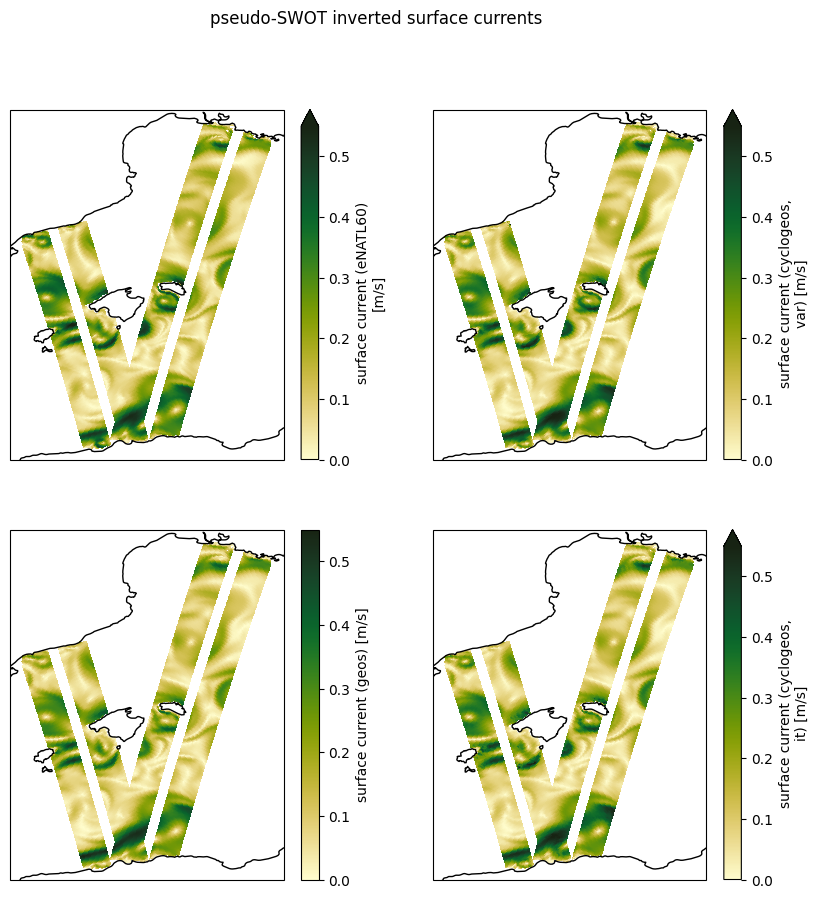

In [37]:
fig, axes = plt.subplots(2, 2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 10))

uv_003_da.where(karin_003_mask).plot.pcolormesh(ax=axes[0, 0], x="lon", y="lat", vmin=0, vmax=0.55, cmap=cmo.speed)
uv_016_da.where(karin_016_mask).plot.pcolormesh(
    ax=axes[0, 0], x="lon", y="lat", vmin=0, vmax=0.55, cmap=cmo.speed, add_colorbar=False
)
axes[0, 0].coastlines()
uv_g_003_da.plot.pcolormesh(ax=axes[1, 0], x="lon", y="lat", vmin=0, vmax=0.55, cmap=cmo.speed)
uv_g_016_da.plot.pcolormesh(ax=axes[1, 0], x="lon", y="lat", vmin=0, vmax=0.55, cmap=cmo.speed, add_colorbar=False)
axes[1, 0].coastlines()
uv_cg_var_003_da.plot.pcolormesh(ax=axes[0, 1], x="lon", y="lat", vmin=0, vmax=0.55, cmap=cmo.speed)
uv_cg_var_016_da.plot.pcolormesh(ax=axes[0, 1], x="lon", y="lat", vmin=0, vmax=0.55, cmap=cmo.speed, add_colorbar=False)
axes[0, 1].coastlines()
uv_cg_it_003_da.plot.pcolormesh(ax=axes[1, 1], x="lon", y="lat", vmin=0, vmax=0.55, cmap=cmo.speed)
uv_cg_it_016_da.plot.pcolormesh(ax=axes[1, 1], x="lon", y="lat", vmin=0, vmax=0.55, cmap=cmo.speed, add_colorbar=False)
axes[1, 1].coastlines()

fig.suptitle("pseudo-SWOT inverted surface currents")
plt.show()

In [38]:
u_003_ref = jnp.asarray(u_003_da.values)
v_003_ref = jnp.asarray(v_003_da.values)

uv_err_g_003, uv_err_cg_var_003, uv_err_cg_it_003 = map(
    lambda u, v: magnitude(u - u_003_ref, v - v_003_ref), 
    (u_g_003, u_cg_var_003, u_cg_it_003), (v_g_003, v_cg_var_003, v_cg_it_003)
)

In [39]:
uv_g_err_003_da, uv_cg_err_var_003_da, uv_cg_err_it_003_da = map(
    lambda arr, method: arr_to_da(
        arr, ssh_003_da.lat, ssh_003_da.lon, f"surface current error ({method})", units="m/s"
    ),
    (uv_err_g_003, uv_err_cg_var_003, uv_err_cg_it_003), ("geos", "cyclogeos, var", "cyclogeos, it")
)

In [40]:
u_016_ref = jnp.asarray(u_016_da.values)
v_016_ref = jnp.asarray(v_016_da.values)

uv_err_g_016, uv_err_cg_var_016, uv_err_cg_it_016 = map(
    lambda u, v: magnitude(u - u_016_ref, v - v_016_ref), 
    (u_g_016, u_cg_var_016, u_cg_it_016), (v_g_016, v_cg_var_016, v_cg_it_016)
)

In [41]:
uv_g_err_016_da, uv_cg_err_var_016_da, uv_cg_err_it_016_da = map(
    lambda arr, method: arr_to_da(
        arr, ssh_016_da.lat, ssh_016_da.lon, f"surface current error ({method})", units="m/s"
    ),
    (uv_err_g_016, uv_err_cg_var_016, uv_err_cg_it_016), ("geos", "cyclogeos, var", "cyclogeos, it")
)

In [42]:
(
    np.nanmean(np.concatenate([np.ravel(uv_err_cg_it_003), np.ravel(uv_err_g_016)])), 
    np.nanmean(np.concatenate([np.ravel(uv_err_cg_var_003), np.ravel(uv_err_cg_var_016)])), 
    np.nanmean(np.concatenate([np.ravel(uv_err_cg_it_003), np.ravel(uv_err_cg_it_016)])), 
)

(0.054087644654069116, 0.052521791421959785, 0.05279258565045568)

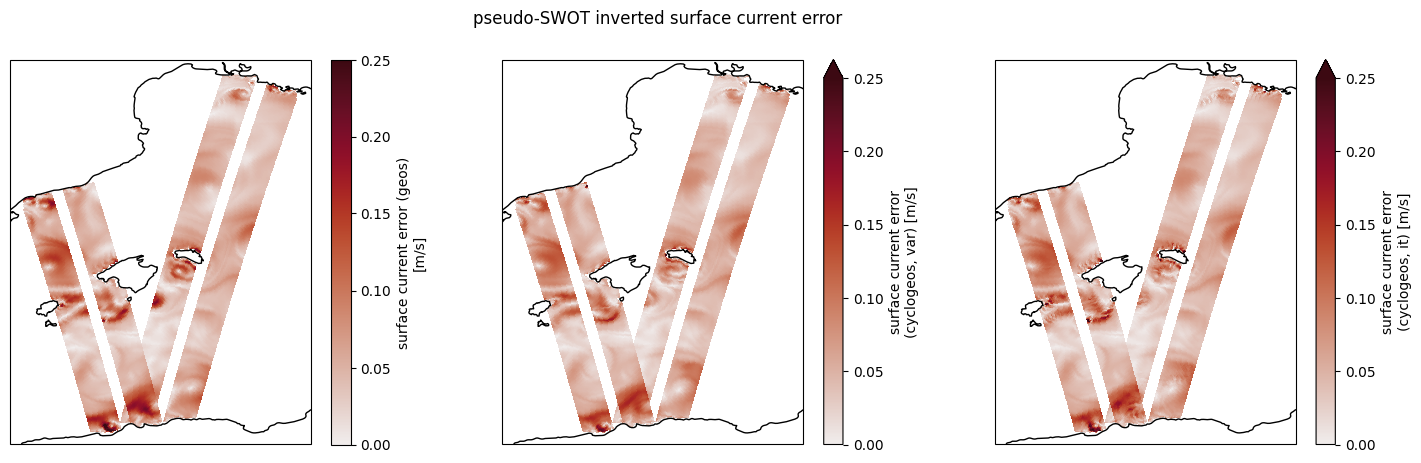

In [43]:
fig, axes = plt.subplots(1, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(18, 5))

uv_g_err_003_da.plot.pcolormesh(ax=axes[0], x="lon", y="lat", vmin=0, vmax=0.25, cmap=cmo.amp)
uv_g_err_016_da.plot.pcolormesh(ax=axes[0], x="lon", y="lat", vmin=0, vmax=0.25, cmap=cmo.amp, add_colorbar=False)
axes[0].coastlines()
uv_cg_err_var_003_da.plot.pcolormesh(ax=axes[1], x="lon", y="lat", vmin=0, vmax=0.25, cmap=cmo.amp)
uv_cg_err_var_016_da.plot.pcolormesh(ax=axes[1], x="lon", y="lat", vmin=0, vmax=0.25, cmap=cmo.amp, add_colorbar=False)
axes[1].coastlines()
uv_cg_err_it_003_da.plot.pcolormesh(ax=axes[2], x="lon", y="lat", vmin=0, vmax=0.25, cmap=cmo.amp)
uv_cg_err_it_016_da.plot.pcolormesh(ax=axes[2], x="lon", y="lat", vmin=0, vmax=0.25, cmap=cmo.amp, add_colorbar=False)
axes[2].coastlines()

fig.suptitle("pseudo-SWOT inverted surface current error")
plt.show()

In [44]:
uv_err_imp_vs_geos_003 = (uv_err_g_003 - uv_err_cg_var_003)
uv_err_imp_vs_it_003 = (uv_err_cg_it_003 - uv_err_cg_var_003)

In [45]:
uv_err_imp_vs_geos_003_da, uv_err_imp_vs_it_003_da = map(
    lambda arr, vs: arr_to_da(
        arr, ssh_003_da.lat, ssh_003_da.lon, f"surface current error improvement vs. {vs}", units="m/s"
    ),
    (uv_err_imp_vs_geos_003, uv_err_imp_vs_it_003), ("geos", "cyclogeos, it")
)

In [46]:
uv_err_imp_vs_geos_016 = (uv_err_g_016 - uv_err_cg_var_016)
uv_err_imp_vs_it_016 = (uv_err_cg_it_016 - uv_err_cg_var_016)

In [47]:
uv_err_imp_vs_geos_016_da, uv_err_imp_vs_it_016_da = map(
    lambda arr, vs: arr_to_da(
        arr, ssh_016_da.lat, ssh_016_da.lon, f"surface current error improvement vs. {vs}", units="m/s"
    ),
    (uv_err_imp_vs_geos_016, uv_err_imp_vs_it_016), ("geos", "cyclogeos, it")
)

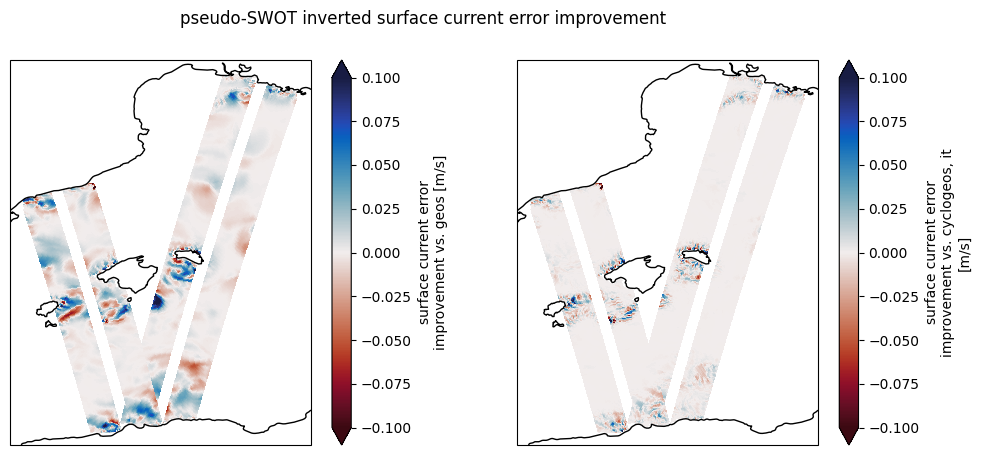

In [48]:
fig, axes = plt.subplots(1, 2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(12, 5))

uv_err_imp_vs_geos_003_da.plot.pcolormesh(ax=axes[0], x="lon", y="lat", vmin=-0.1, vmax=0.1, cmap=cmo.balance_r)
uv_err_imp_vs_geos_016_da.plot.pcolormesh(
    ax=axes[0], x="lon", y="lat", vmin=-0.1, vmax=0.1, cmap=cmo.balance_r, add_colorbar=False
)
axes[0].coastlines()
uv_err_imp_vs_it_003_da.plot.pcolormesh(ax=axes[1], x="lon", y="lat", vmin=-0.1, vmax=0.1, cmap=cmo.balance_r)
uv_err_imp_vs_it_016_da.plot.pcolormesh(
    ax=axes[1], x="lon", y="lat", vmin=-0.1, vmax=0.1, cmap=cmo.balance_r, add_colorbar=False
)
axes[1].coastlines()

fig.suptitle("pseudo-SWOT inverted surface current error improvement")
plt.show()

# Comparison with eNATL60 normalized relative vorticity

In [49]:
nrv_g_003_da, nrv_cg_var_003_da, nrv_cg_it_003_da = map(
    lambda arr, method: arr_to_da(
        arr, ssh_003_da.lat, ssh_003_da.lon, f"normalized relative vorticity ({method})"
    ),
    (nrv_g_003, nrv_cg_var_003, nrv_cg_it_003), ("geos", "cyclogeos, var", "cyclogeos, it")
)

In [50]:
nrv_g_016_da, nrv_cg_var_016_da, nrv_cg_it_016_da = map(
    lambda arr, method: arr_to_da(
        arr, ssh_016_da.lat, ssh_016_da.lon, f"normalized relative vorticity ({method})"
    ),
    (nrv_g_016, nrv_cg_var_016, nrv_cg_it_016), ("geos", "cyclogeos, var", "cyclogeos, it")
)

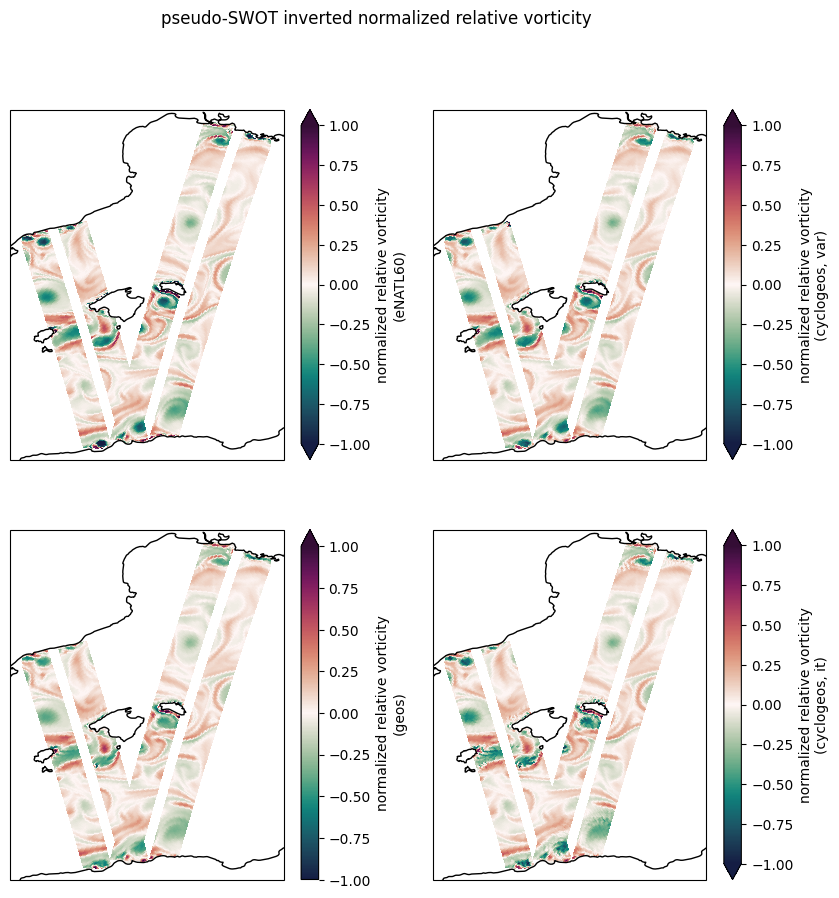

In [51]:
fig, axes = plt.subplots(2, 2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 10))

nrv_003_da.where(karin_003_mask).plot.pcolormesh(ax=axes[0, 0], x="lon", y="lat", vmin=-1, vmax=1, cmap=cmo.curl)
nrv_016_da.where(karin_016_mask).plot.pcolormesh(
    ax=axes[0, 0], x="lon", y="lat", vmin=-1, vmax=1, cmap=cmo.curl, add_colorbar=False
)
axes[0, 0].coastlines()
nrv_g_003_da.plot.pcolormesh(ax=axes[1, 0], x="lon", y="lat", vmin=-1, vmax=1, cmap=cmo.curl)
nrv_g_016_da.plot.pcolormesh(
    ax=axes[1, 0], x="lon", y="lat", vmin=-1, vmax=1, cmap=cmo.curl, add_colorbar=False
)
axes[1, 0].coastlines()
nrv_cg_var_003_da.plot.pcolormesh(ax=axes[0, 1], x="lon", y="lat", vmin=-1, vmax=1, cmap=cmo.curl)
nrv_cg_var_016_da.plot.pcolormesh(
    ax=axes[0, 1], x="lon", y="lat", vmin=-1, vmax=1, cmap=cmo.curl, add_colorbar=False
)
axes[0, 1].coastlines()
nrv_cg_it_003_da.plot.pcolormesh(ax=axes[1, 1], x="lon", y="lat", vmin=-1, vmax=1, cmap=cmo.curl)
nrv_cg_it_016_da.plot.pcolormesh(
    ax=axes[1, 1], x="lon", y="lat", vmin=-1, vmax=1, cmap=cmo.curl, add_colorbar=False
)
axes[1, 1].coastlines()

fig.suptitle("pseudo-SWOT inverted normalized relative vorticity")
plt.show()

In [52]:
nrv_ref_003 = nrv_003_da.values

nrv_err_g_003, nrv_err_cg_var_003, nrv_err_cg_it_003 = map(
    lambda nrv_est: np.abs(nrv_ref_003 - nrv_est), 
    (nrv_g_003, nrv_cg_var_003, nrv_cg_it_003)
)

In [53]:
nrv_g_err_003_da, nrv_cg_err_var_003_da, nrv_cg_err_it_003_da = map(
    lambda arr, method: arr_to_da(
        arr, ssh_003_da.lat, ssh_003_da.lon, f"normalized relative vorticity error ({method})"
    ),
    (nrv_err_g_003, nrv_err_cg_var_003, nrv_err_cg_it_003), ("geos", "cyclogeos, var", "cyclogeos, it")
)

In [54]:
nrv_ref_016 = nrv_016_da.values

nrv_err_g_016, nrv_err_cg_var_016, nrv_err_cg_it_016 = map(
    lambda nrv_est: np.abs(nrv_ref_016 - nrv_est), 
    (nrv_g_016, nrv_cg_var_016, nrv_cg_it_016)
)

In [55]:
nrv_g_err_016_da, nrv_cg_err_var_016_da, nrv_cg_err_it_016_da = map(
    lambda arr, method: arr_to_da(
        arr, ssh_016_da.lat, ssh_016_da.lon, f"normalized relative vorticity error ({method})"
    ),
    (nrv_err_g_016, nrv_err_cg_var_016, nrv_err_cg_it_016), ("geos", "cyclogeos, var", "cyclogeos, it")
)

In [56]:
(
    np.nanmean(np.concatenate([np.ravel(nrv_err_g_003), np.ravel(nrv_err_g_016)])), 
    np.nanmean(np.concatenate([np.ravel(nrv_err_cg_var_003), np.ravel(nrv_err_cg_var_016)])), 
    np.nanmean(np.concatenate([np.ravel(nrv_err_cg_it_003), np.ravel(nrv_err_cg_it_016)])), 
)

(0.030450460880644552, 0.022077720282787556, 0.027544765986603888)

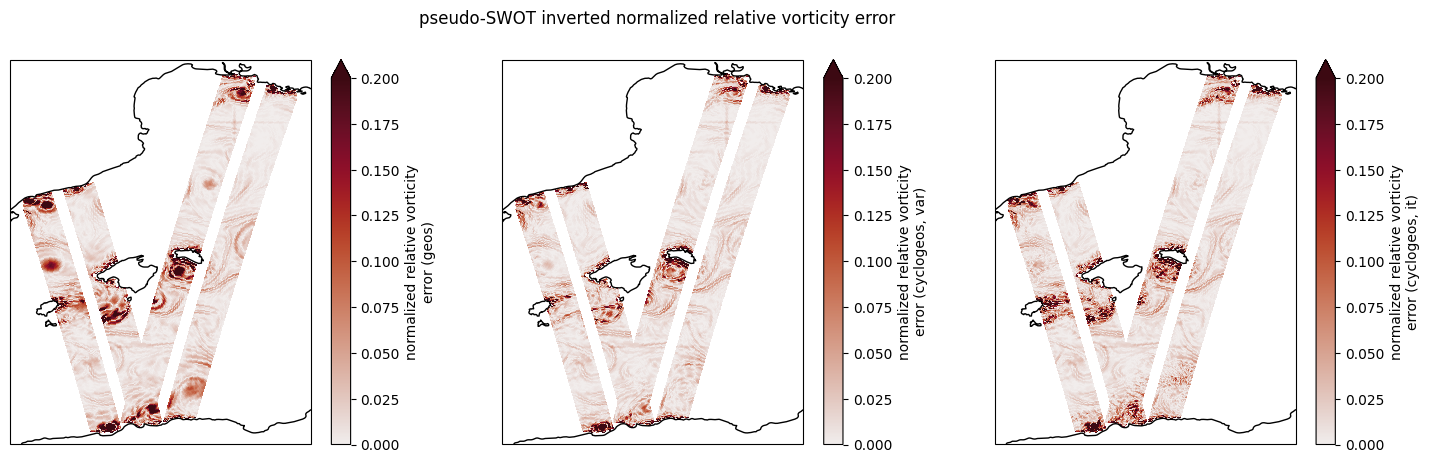

In [57]:
fig, axes = plt.subplots(1, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(18, 5))

nrv_g_err_003_da.plot.pcolormesh(ax=axes[0], x="lon", y="lat", vmin=0, vmax=0.2, cmap=cmo.amp)
nrv_g_err_016_da.plot.pcolormesh(ax=axes[0], x="lon", y="lat", vmin=0, vmax=0.2, cmap=cmo.amp, add_colorbar=False)
axes[0].coastlines()
nrv_cg_err_var_003_da.plot.pcolormesh(ax=axes[1], x="lon", y="lat", vmin=0, vmax=0.2, cmap=cmo.amp)
nrv_cg_err_var_016_da.plot.pcolormesh(ax=axes[1], x="lon", y="lat", vmin=0, vmax=0.2, cmap=cmo.amp, add_colorbar=False)
axes[1].coastlines()
nrv_cg_err_it_003_da.plot.pcolormesh(ax=axes[2], x="lon", y="lat", vmin=0, vmax=0.2, cmap=cmo.amp)
nrv_cg_err_it_016_da.plot.pcolormesh(ax=axes[2], x="lon", y="lat", vmin=0, vmax=0.2, cmap=cmo.amp, add_colorbar=False)
axes[2].coastlines()

fig.suptitle("pseudo-SWOT inverted normalized relative vorticity error")
plt.show()

In [58]:
nrv_err_imp_vs_geos_003 = (nrv_err_g_003 - nrv_err_cg_var_003)
nrv_err_imp_vs_it_003 = (nrv_err_cg_it_003 - nrv_err_cg_var_003)

In [59]:
nrv_err_imp_vs_geos_003_da, nrv_err_imp_vs_it_003_da = map(
    lambda arr, vs: arr_to_da(
        arr, ssh_003_da.lat, ssh_003_da.lon, f"normalized relative vorticity error improvement vs. {vs}"
    ),
    (nrv_err_imp_vs_geos_003, nrv_err_imp_vs_it_003), ("geos", "cyclogeos, it")
)

In [60]:
nrv_err_imp_vs_geos_016 = (nrv_err_g_016 - nrv_err_cg_var_016)
nrv_err_imp_vs_it_016 = (nrv_err_cg_it_016 - nrv_err_cg_var_016)

In [61]:
nrv_err_imp_vs_geos_016_da, nrv_err_imp_vs_it_016_da = map(
    lambda arr, vs: arr_to_da(
        arr, ssh_016_da.lat, ssh_016_da.lon, f"normalized relative vorticity error improvement vs. {vs}"
    ),
    (nrv_err_imp_vs_geos_016, nrv_err_imp_vs_it_016), ("geos", "cyclogeos, it")
)

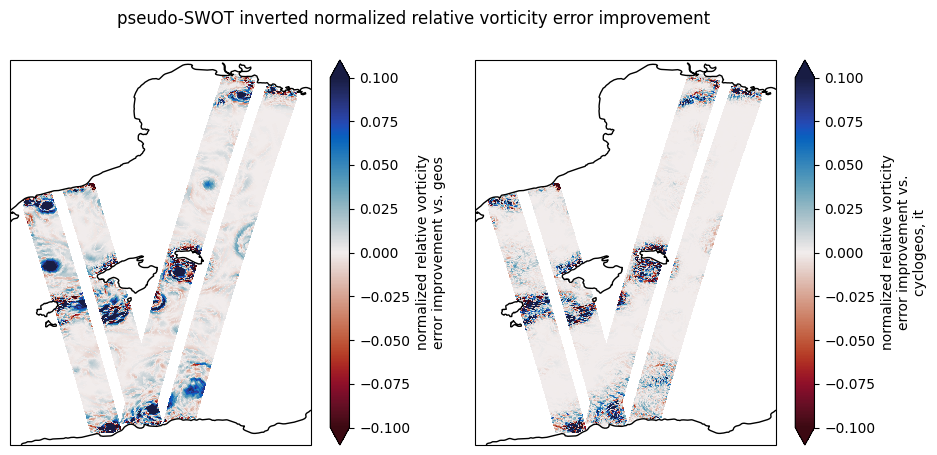

In [62]:
fig, axes = plt.subplots(1, 2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(11, 5))

nrv_err_imp_vs_geos_003_da.plot.pcolormesh(ax=axes[0], x="lon", y="lat", vmin=-0.1, vmax=0.1, cmap=cmo.balance_r)
nrv_err_imp_vs_geos_016_da.plot.pcolormesh(
    ax=axes[0], x="lon", y="lat", vmin=-0.1, vmax=0.1, cmap=cmo.balance_r, add_colorbar=False
)
axes[0].coastlines()
nrv_err_imp_vs_it_003_da.plot.pcolormesh(ax=axes[1], x="lon", y="lat", vmin=-0.1, vmax=0.1, cmap=cmo.balance_r)
nrv_err_imp_vs_it_016_da.plot.pcolormesh(
    ax=axes[1], x="lon", y="lat", vmin=-0.1, vmax=0.1, cmap=cmo.balance_r, add_colorbar=False
)
axes[1].coastlines()

fig.suptitle("pseudo-SWOT inverted normalized relative vorticity error improvement")
plt.show()